## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import missingno as msno ## visualization of missing values
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)


import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
#import catboost as cat
import time
from collections import Counter
import datetime
#from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
#import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', 1000)
np.random.seed(566)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

## Load datasets

In [3]:
train=pd.read_csv('../data/training_v2.csv')
test=pd.read_csv('../data/unlabeled.csv')

## According to part 1 EDA, I would like to remove readmission_status
## And replace -1 with nan in both apache_4a_hospital_death_prob and apache_4a_icu_death_prob
train=train.drop(['readmission_status'], axis=1 )
train['apache_4a_hospital_death_prob']=train['apache_4a_hospital_death_prob'].replace(-1, np.nan)
train['apache_4a_icu_death_prob']=train['apache_4a_icu_death_prob'].replace(-1, np.nan)

## Feature selection 

In [3]:
## define metrics to evaluate models
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc 

In [47]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  182


In [71]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [72]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

Transform categorical features with string values by LabelEncoder

In [73]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categorical_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for null values so we start at 1 
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



In [8]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

Tune LightGBM model with BayesianOptimization

In [62]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categorical_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if 0 : 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [63]:
params = {'feature_fraction': 0.9,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'learning_rate': 0.1,
 'max_depth': 13,
 'subsample_freq': 1,
 'scale_pos_weight':1}

In [35]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.951263	valid_1's auc: 0.904279
[200]	training's auc: 0.976733	valid_1's auc: 0.904767
Early stopping, best iteration is:
[128]	training's auc: 0.960452	valid_1's auc: 0.90528
Partial score of fold 0 is: 0.9052799584487325
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950149	valid_1's auc: 0.900578
[200]	training's auc: 0.977344	valid_1's auc: 0.902054
[300]	training's auc: 0.989828	valid_1's auc: 0.901951
Early stopping, best iteration is:
[230]	training's auc: 0.981907	valid_1's auc: 0.902476
Partial score of fold 1 is: 0.9024764540305182
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.951171	valid_1's auc: 0.905617
[200]	training's auc: 0.975993	valid_1's auc: 0.906761
[300]	training's auc: 0.989145	valid_1's auc: 0.906262
Early stopping, best iteration is:
[215]	training's auc: 0.978719	valid_1's auc: 0.907005
Partial 

First submission with score=0.9015

In [36]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission1.csv",index=False)

### Adversarial Validation

In [48]:
def adversarial_validation(train, test, features):
    
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set   = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

In [49]:
adversarial_features = adversarial_validation(train, test, features)

Fold 1
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.999803	valid_1's auc: 0.999741
Fold 2
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.999842	valid_1's auc: 0.999746
Fold 3
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.999916	valid_1's auc: 0.999713
Fold 4
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[29]	training's auc: 0.99999	valid_1's auc: 0.999709
Fold 5
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.999911	valid_1's auc: 0.999667
Our mean train roc auc score is : 0.9998922722408417
Our oof roc auc score is : 0.996912262580531


In [51]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

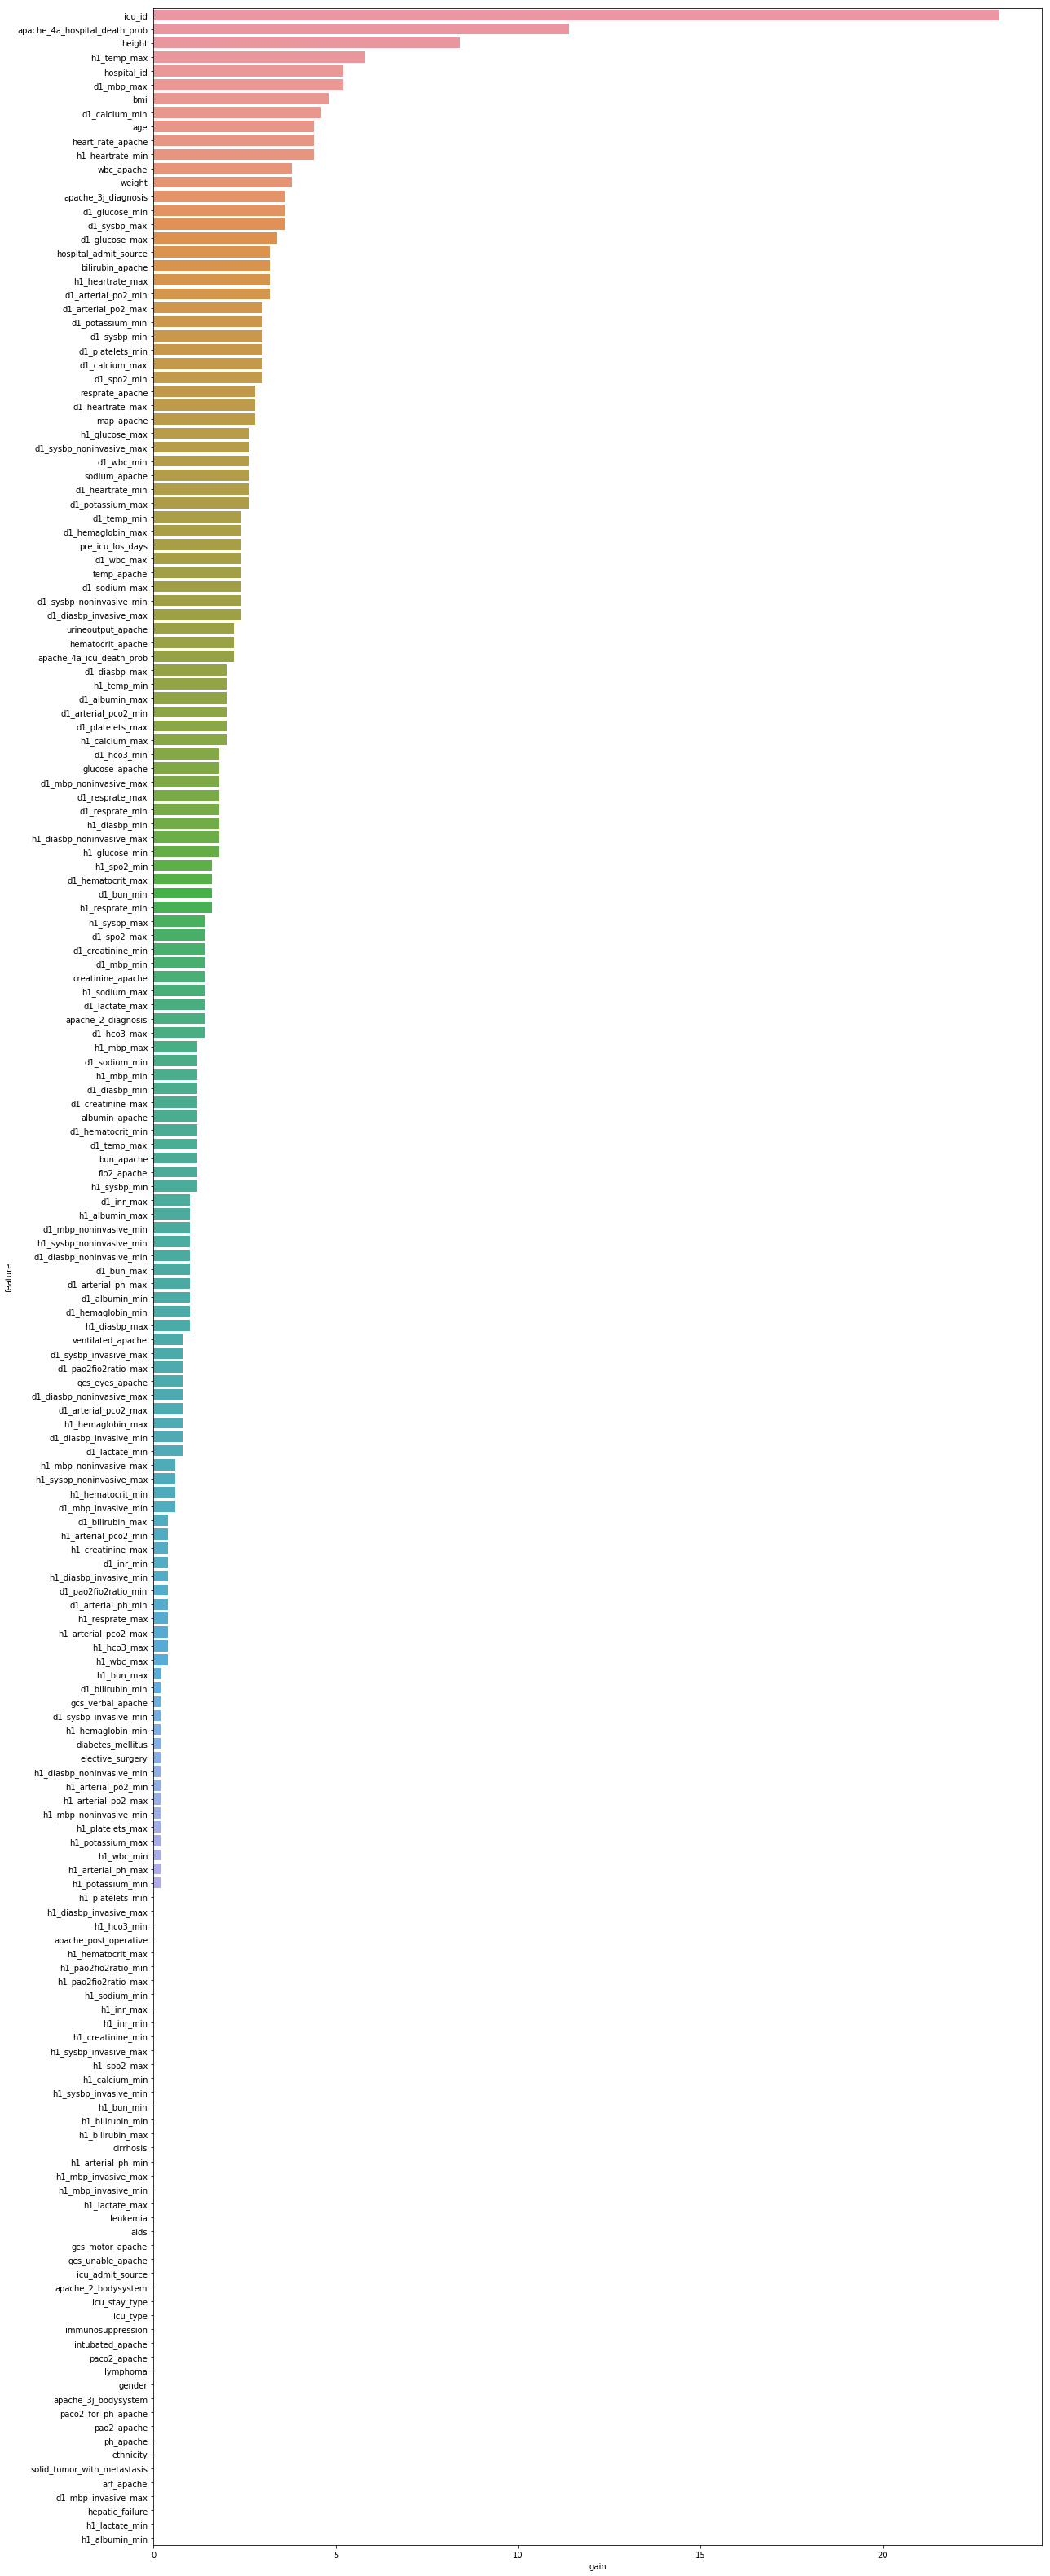

In [52]:
adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)
plot_importances(adversarial_features)

icu_id 0 gain : 23.2


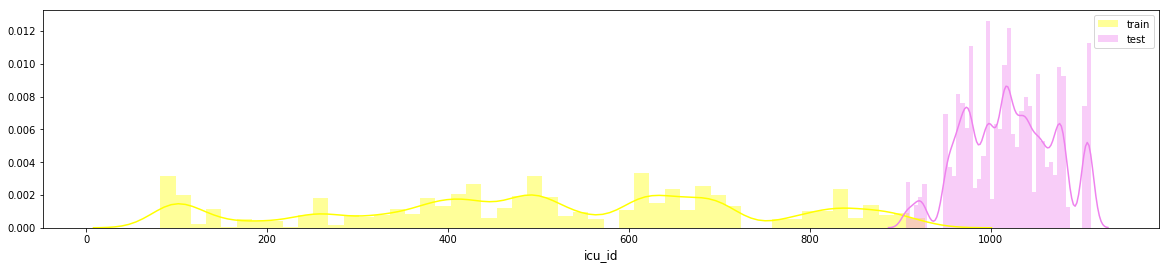

apache_4a_hospital_death_prob 1 gain : 11.4


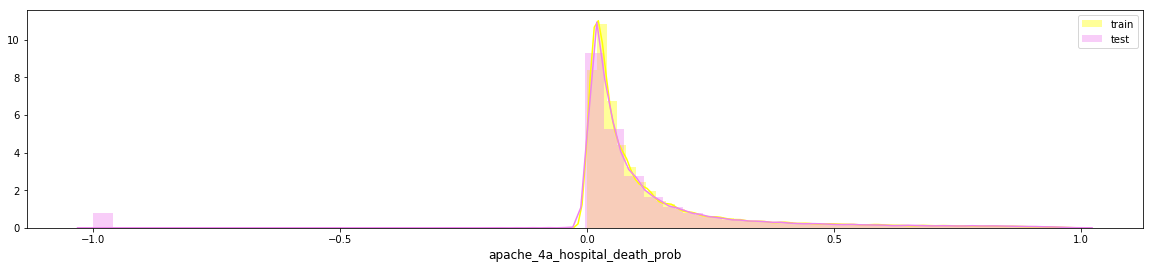

height 2 gain : 8.4


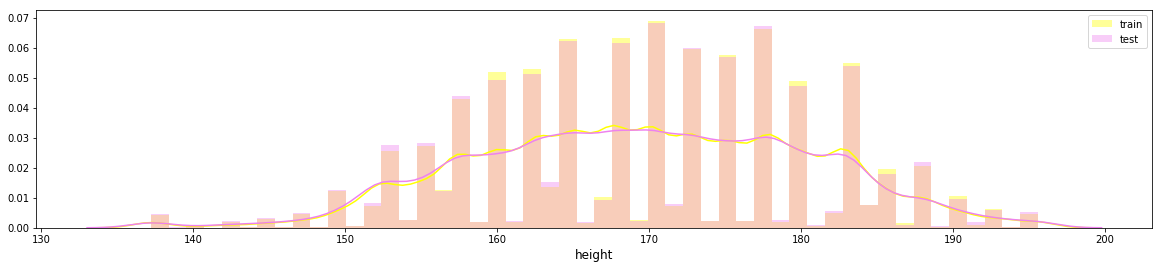

h1_temp_max 3 gain : 5.8


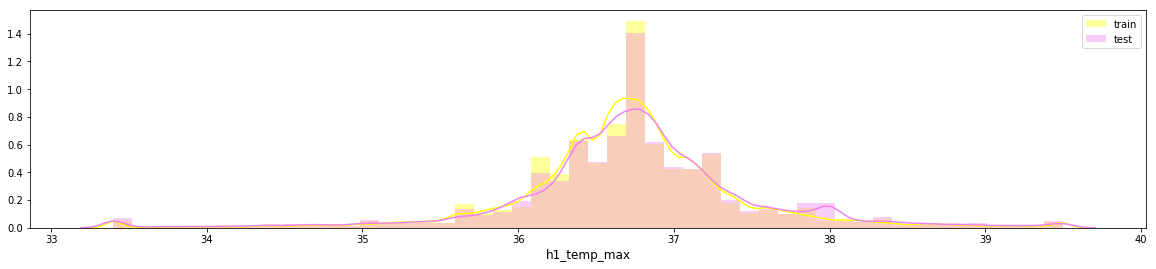

In [54]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 4:
            print(column,i,"gain :",row['gain'])
            df1      = train.copy()
            df2      = test.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

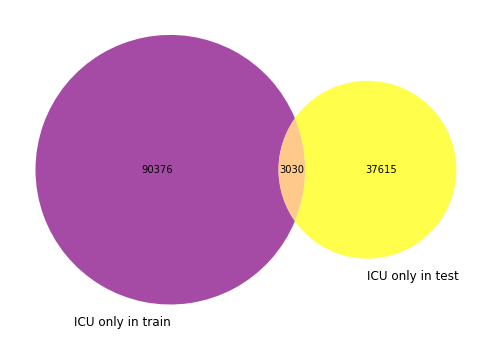

In [57]:
common_id  = list([id for id in train['icu_id'].unique() if id in test['icu_id'].unique() ])
id_only_in_train  = [id for id in train['icu_id'].unique() if id not in test['icu_id'].unique() ]
id_only_in_test   = [id for id in test['icu_id'].unique()  if id not in train['icu_id'].unique() ]
count_common_train = train.loc[train['icu_id'].isin(common_id)].shape[0]
count_common_test  = test.loc[test['icu_id'].isin(common_id)].shape[0]

count_train = train.loc[train['icu_id'].isin(id_only_in_train)].shape[0]
count_test  = test.loc[test['icu_id'].isin(id_only_in_test)].shape[0]
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 
fig = plt.figure(figsize=(20,6))
venn2(subsets = (count_train,  count_test, count_common_train+count_common_test), set_labels = ('ICU only in train', 'ICU only in test'),set_colors=('purple', 'yellow'), alpha = 0.7);
plt.show()

In [58]:
# remove icu_id
adversarial_features2 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.999755	valid_1's auc: 0.999687
Early stopping, best iteration is:
[154]	training's auc: 0.999947	valid_1's auc: 0.999715
Fold 2
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.999756	valid_1's auc: 0.999674
Early stopping, best iteration is:
[170]	training's auc: 0.999966	valid_1's auc: 0.999715
Fold 3
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.999746	valid_1's auc: 0.999642
Early stopping, best iteration is:
[146]	training's auc: 0.999925	valid_1's auc: 0.999676
Fold 4
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.999787	valid_1's auc: 0.999595
[200]	training's auc: 0.999992	valid_1's auc: 0.999672
Early stopping, best iteration is:
[199]	training's auc: 0.999992	valid_1's auc: 0.999673
Fold 5
Training until validation scores don't improve for 20 rounds.
[100]	training's auc

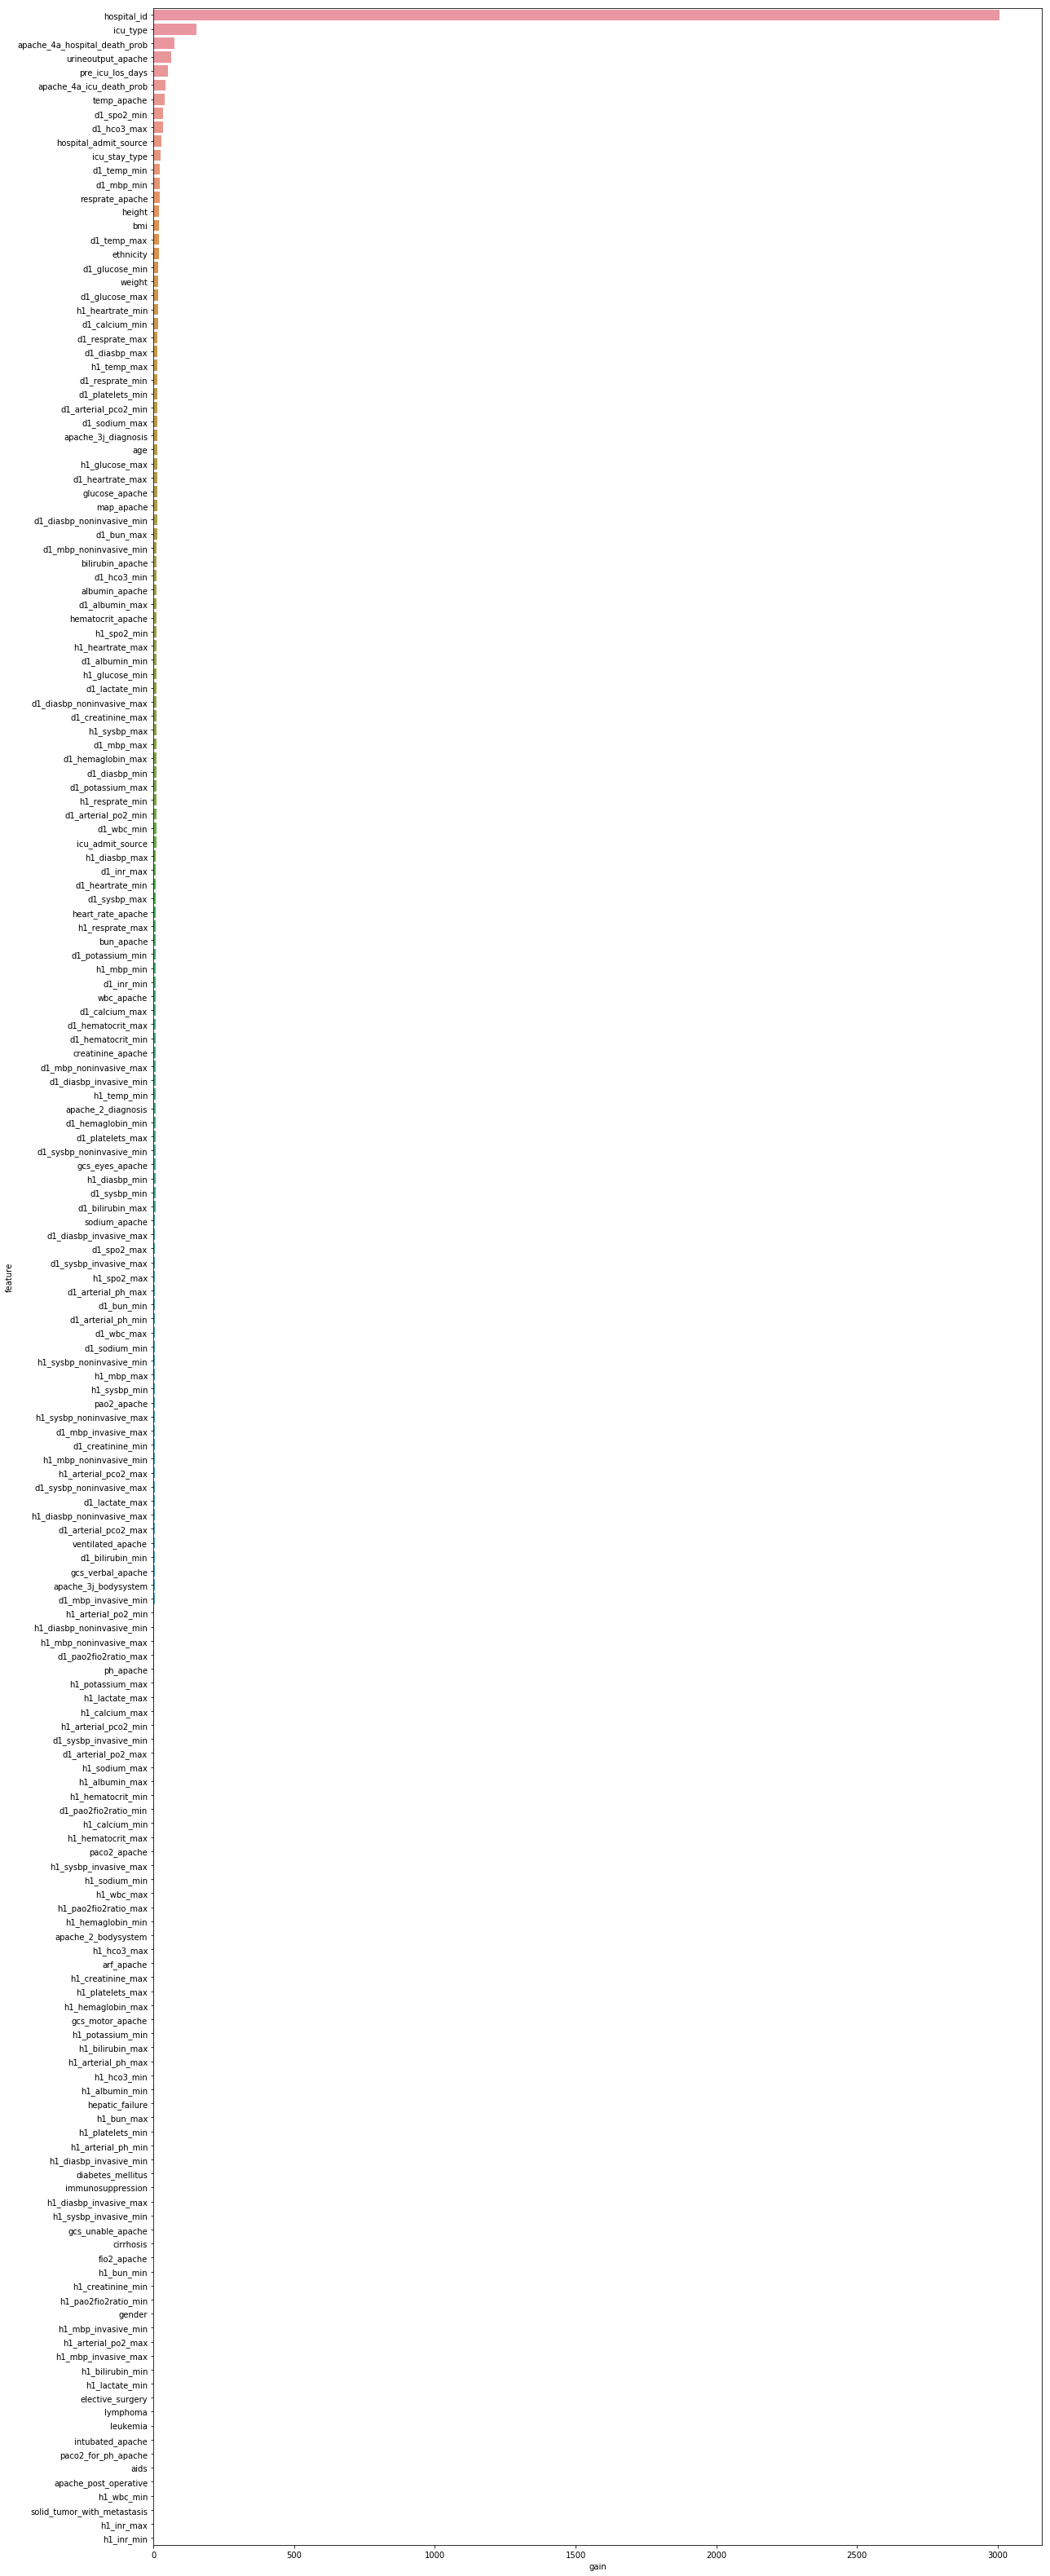

In [59]:
adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)
plot_importances(adversarial_features2)

hospital_id 0 gain : 3006.4


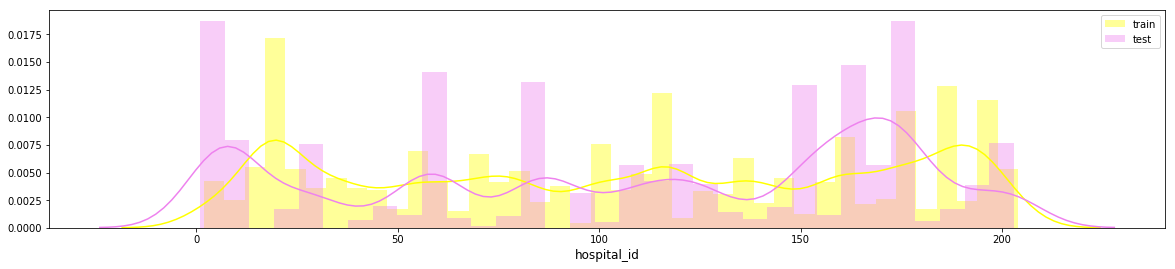

icu_type 1 gain : 152.0


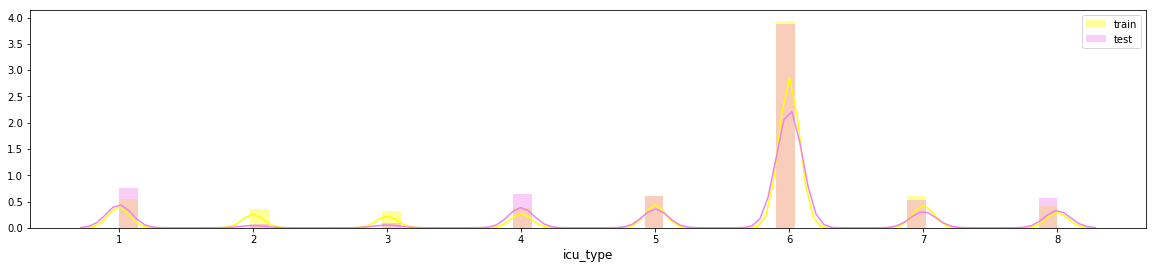

apache_4a_hospital_death_prob 2 gain : 75.6


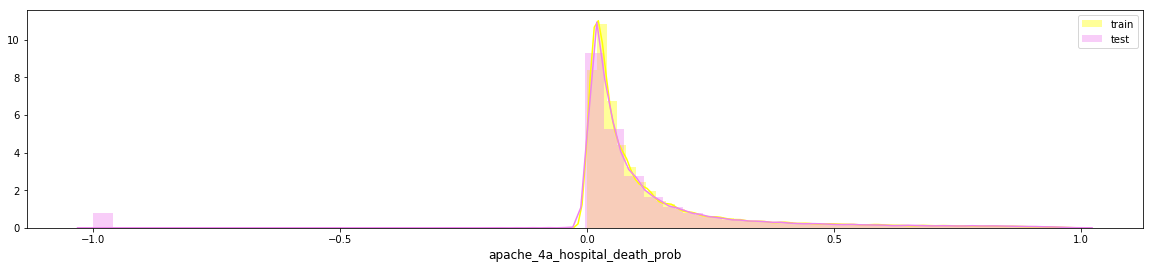

urineoutput_apache 3 gain : 62.6


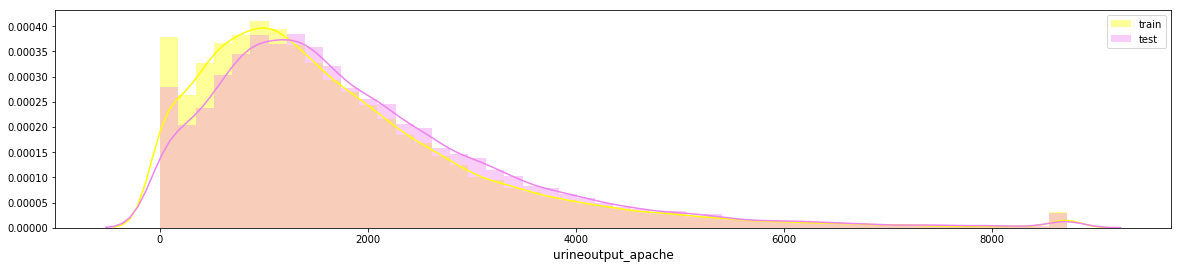

In [61]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features2.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 4:
            print(column,i,"gain :",row['gain'])
            df1      = train.copy()
            df2      = test.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

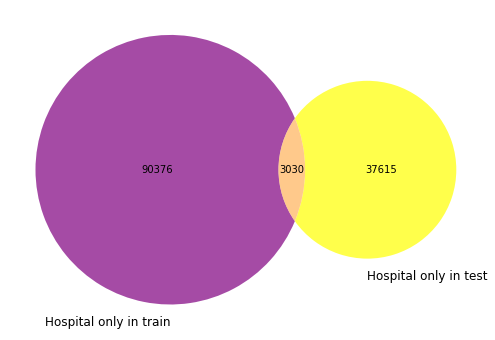

In [62]:
common_id  = list([id for id in train['hospital_id'].unique() if id in test['hospital_id'].unique() ])
id_only_in_train  = [id for id in train['hospital_id'].unique() if id not in test['hospital_id'].unique() ]
id_only_in_test   = [id for id in test['hospital_id'].unique()  if id not in train['hospital_id'].unique() ]
count_common_train = train.loc[train['hospital_id'].isin(common_id)].shape[0]
count_common_test  = test.loc[test['hospital_id'].isin(common_id)].shape[0]

count_train = train.loc[train['hospital_id'].isin(id_only_in_train)].shape[0]
count_test  = test.loc[test['hospital_id'].isin(id_only_in_test)].shape[0]
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 
fig = plt.figure(figsize=(20,6))
venn2(subsets = (count_train,  count_test, count_common_train+count_common_test), set_labels = ('Hospital only in train', 'Hospital only in test'),set_colors=('purple', 'yellow'), alpha = 0.7);
plt.show()

In [63]:
adversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.905622	valid_1's auc: 0.893003
[200]	training's auc: 0.93378	valid_1's auc: 0.90574
[300]	training's auc: 0.951096	valid_1's auc: 0.911344
[400]	training's auc: 0.963259	valid_1's auc: 0.914167
[500]	training's auc: 0.972322	valid_1's auc: 0.916576
[600]	training's auc: 0.978827	valid_1's auc: 0.918335
Early stopping, best iteration is:
[663]	training's auc: 0.9826	valid_1's auc: 0.91968
Fold 2
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.905699	valid_1's auc: 0.886962
[200]	training's auc: 0.933494	valid_1's auc: 0.899785
[300]	training's auc: 0.95103	valid_1's auc: 0.905647
[400]	training's auc: 0.963069	valid_1's auc: 0.909094
[500]	training's auc: 0.972084	valid_1's auc: 0.911452
[600]	training's auc: 0.978933	valid_1's auc: 0.913268
[700]	training's auc: 0.984066	valid_1's auc: 0.915119
Early stopping, best iteration is:
[702]	training's auc: 0.9841

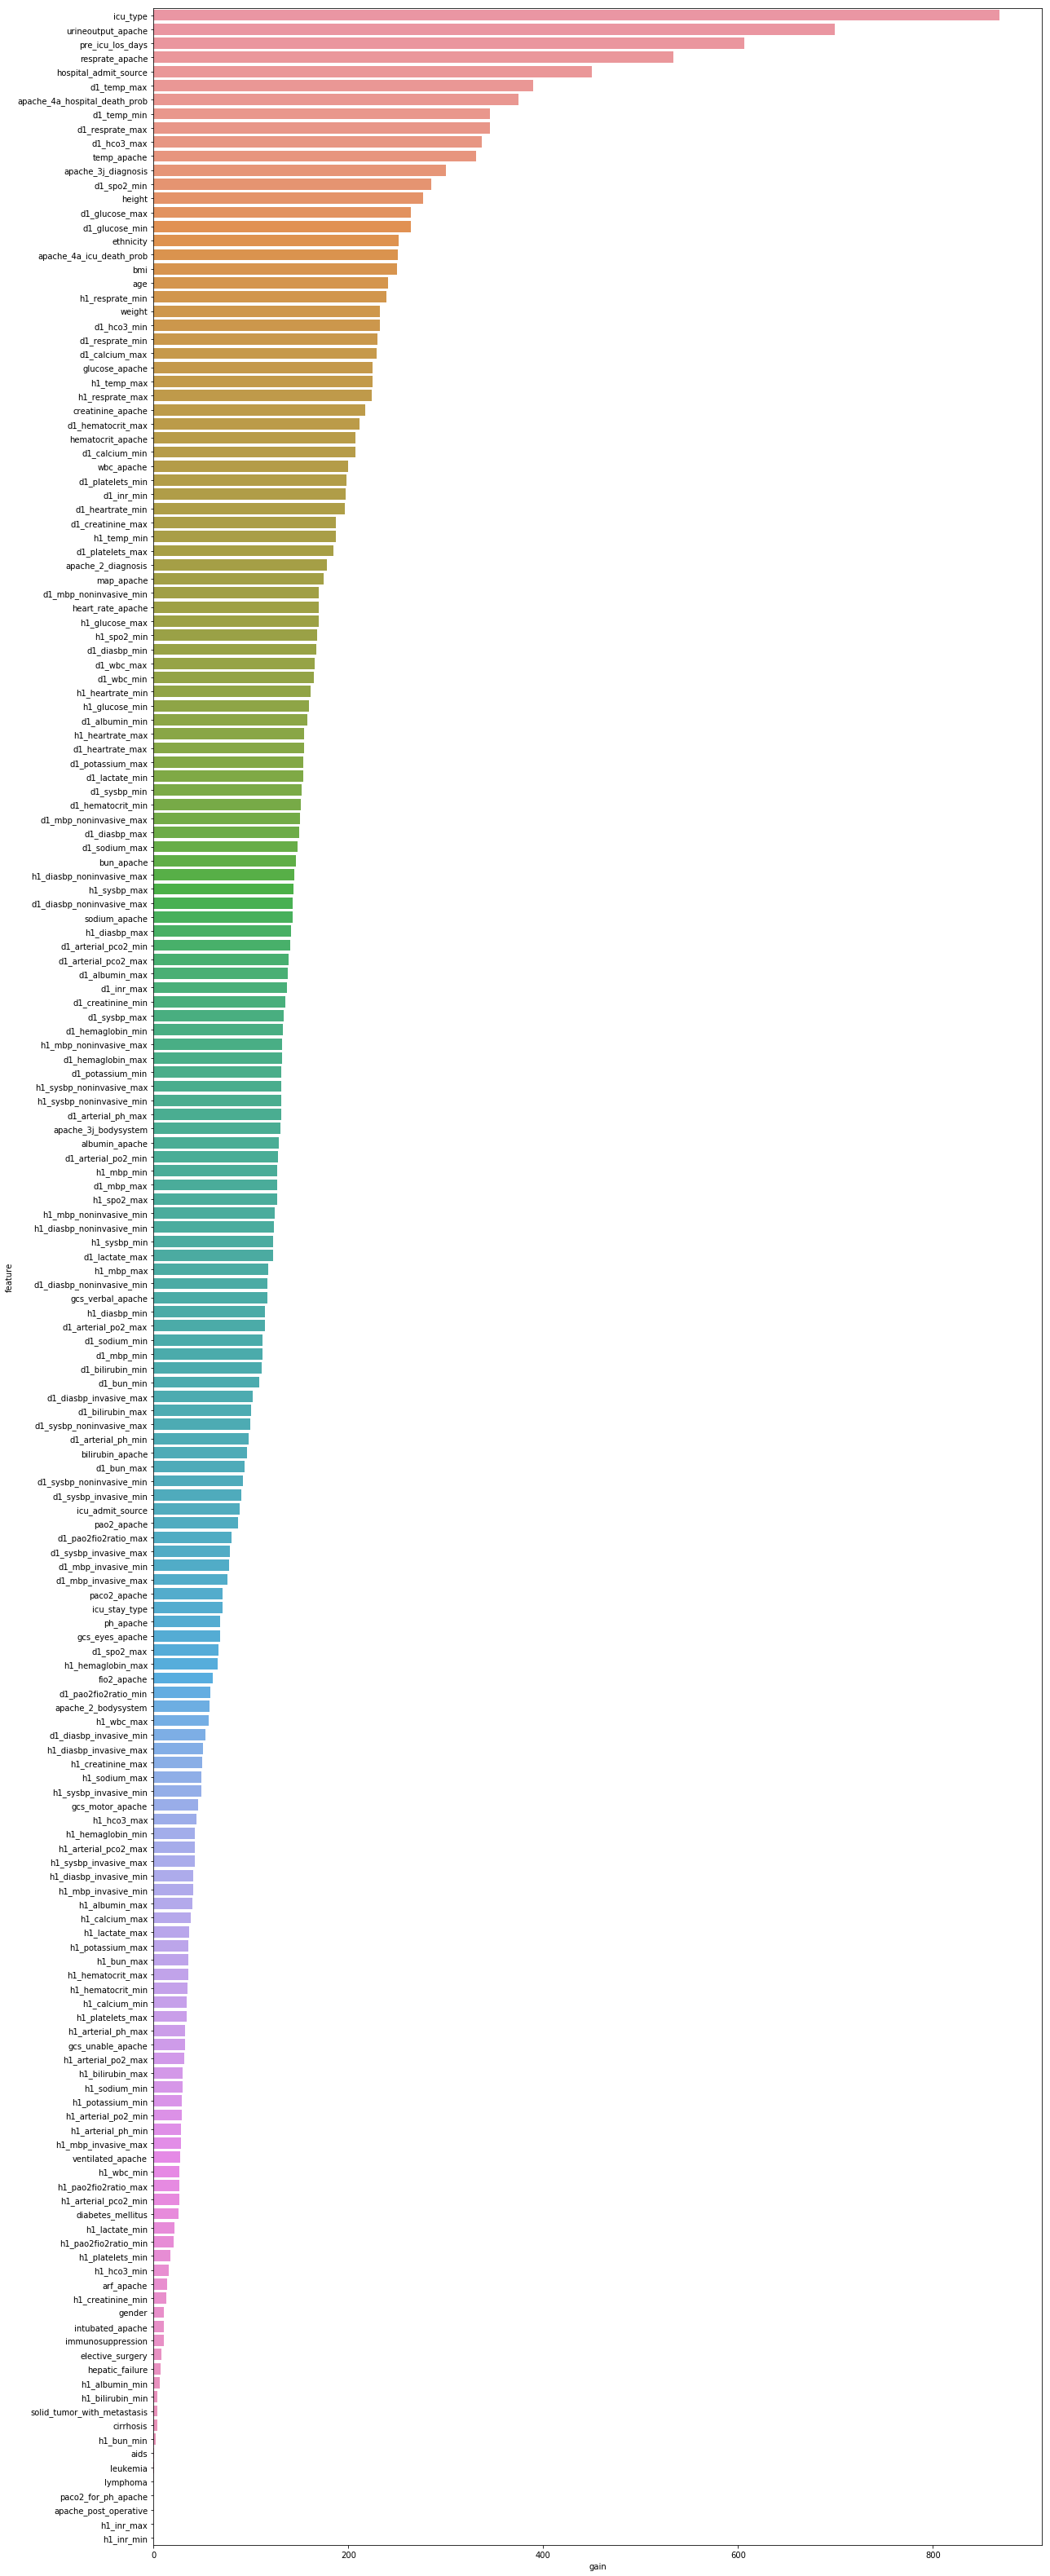

In [67]:
adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)
plot_importances(adversarial_features3)

icu_type 0 gain : 868.4


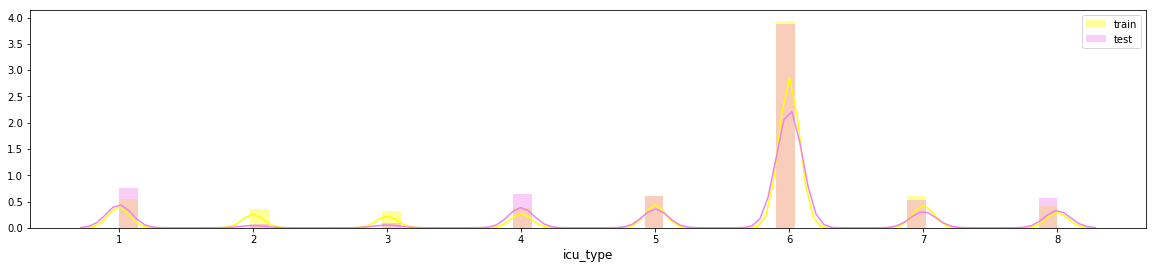

urineoutput_apache 1 gain : 699.2


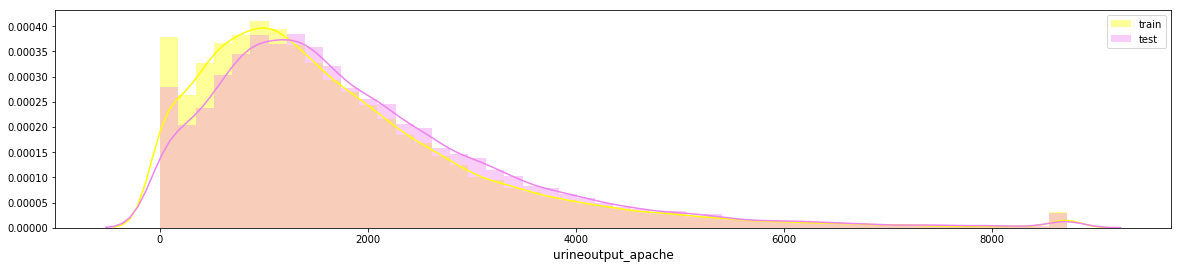

pre_icu_los_days 2 gain : 606.0


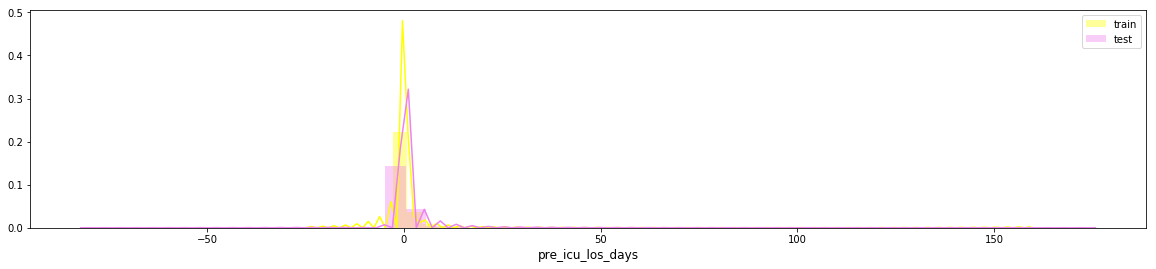

resprate_apache 3 gain : 533.6


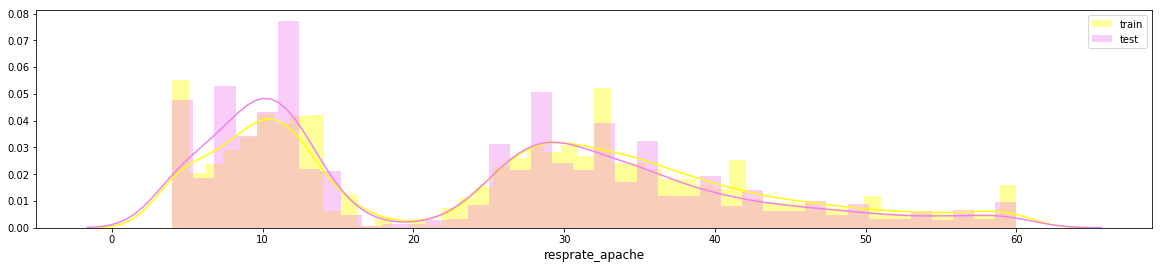

In [66]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features3.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 4:
            print(column,i,"gain :",row['gain'])
            df1      = train.copy()
            df2      = test.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

#### remove hospital_id and icu_id

In [42]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death', 'hospital_id','icu_id']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  180


In [43]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.951914	valid_1's auc: 0.902045
[200]	training's auc: 0.97629	valid_1's auc: 0.902104
Early stopping, best iteration is:
[178]	training's auc: 0.972308	valid_1's auc: 0.902833
Partial score of fold 0 is: 0.9028329792831653
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949751	valid_1's auc: 0.898973
[200]	training's auc: 0.976719	valid_1's auc: 0.900575
[300]	training's auc: 0.989219	valid_1's auc: 0.900059
Early stopping, best iteration is:
[220]	training's auc: 0.980106	valid_1's auc: 0.900912
Partial score of fold 1 is: 0.9009119116146045
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949937	valid_1's auc: 0.905016
[200]	training's auc: 0.975881	valid_1's auc: 0.904298
Early stopping, best iteration is:
[114]	training's auc: 0.955021	valid_1's auc: 0.905078
Partial score of fold 2 is: 0.90507796893304
Training until val

In [44]:
## public score is 0.90161 ## remove hospital_id and icu_id
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission2.csv",index=False)

In [72]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
## remove hospital_id, icu_id and also icu_type
to_drop=['encounter_id','patient_id', 'hospital_death', 'hospital_id','icu_id','icu_type']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  179


In [73]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.9506	valid_1's auc: 0.902763
[200]	training's auc: 0.976414	valid_1's auc: 0.902853
Early stopping, best iteration is:
[192]	training's auc: 0.974997	valid_1's auc: 0.903183
Partial score of fold 0 is: 0.9031827954233299
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949837	valid_1's auc: 0.898872
[200]	training's auc: 0.975307	valid_1's auc: 0.900456
[300]	training's auc: 0.988544	valid_1's auc: 0.899615
Early stopping, best iteration is:
[214]	training's auc: 0.97795	valid_1's auc: 0.90064
Partial score of fold 1 is: 0.9006401548674233
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949639	valid_1's auc: 0.904122
[200]	training's auc: 0.97525	valid_1's auc: 0.905839
[300]	training's auc: 0.988785	valid_1's auc: 0.90567
[400]	training's auc: 0.995086	valid_1's auc: 0.905052
Early stopping, best iteration is:
[326]	trainin

In [74]:
## public score is 0.90287 ## remove hospital_id, icu_id and ict type
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission3.csv",index=False)

In [75]:
adversarial_features4 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id','icu_type'] ])

Fold 1
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.881757	valid_1's auc: 0.863044
[200]	training's auc: 0.913318	valid_1's auc: 0.876295
[300]	training's auc: 0.934672	valid_1's auc: 0.882643
[400]	training's auc: 0.949759	valid_1's auc: 0.886165
[500]	training's auc: 0.961491	valid_1's auc: 0.888931
[600]	training's auc: 0.970522	valid_1's auc: 0.891983
[700]	training's auc: 0.977323	valid_1's auc: 0.893802
[800]	training's auc: 0.982327	valid_1's auc: 0.89524
[900]	training's auc: 0.986503	valid_1's auc: 0.896522
Early stopping, best iteration is:
[922]	training's auc: 0.987205	valid_1's auc: 0.896792
Fold 2
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.882918	valid_1's auc: 0.860544
[200]	training's auc: 0.913949	valid_1's auc: 0.873222
[300]	training's auc: 0.933862	valid_1's auc: 0.878443
[400]	training's auc: 0.949104	valid_1's auc: 0.881479
[500]	training's auc: 0.961019	valid_1's auc: 0.884769
Ear

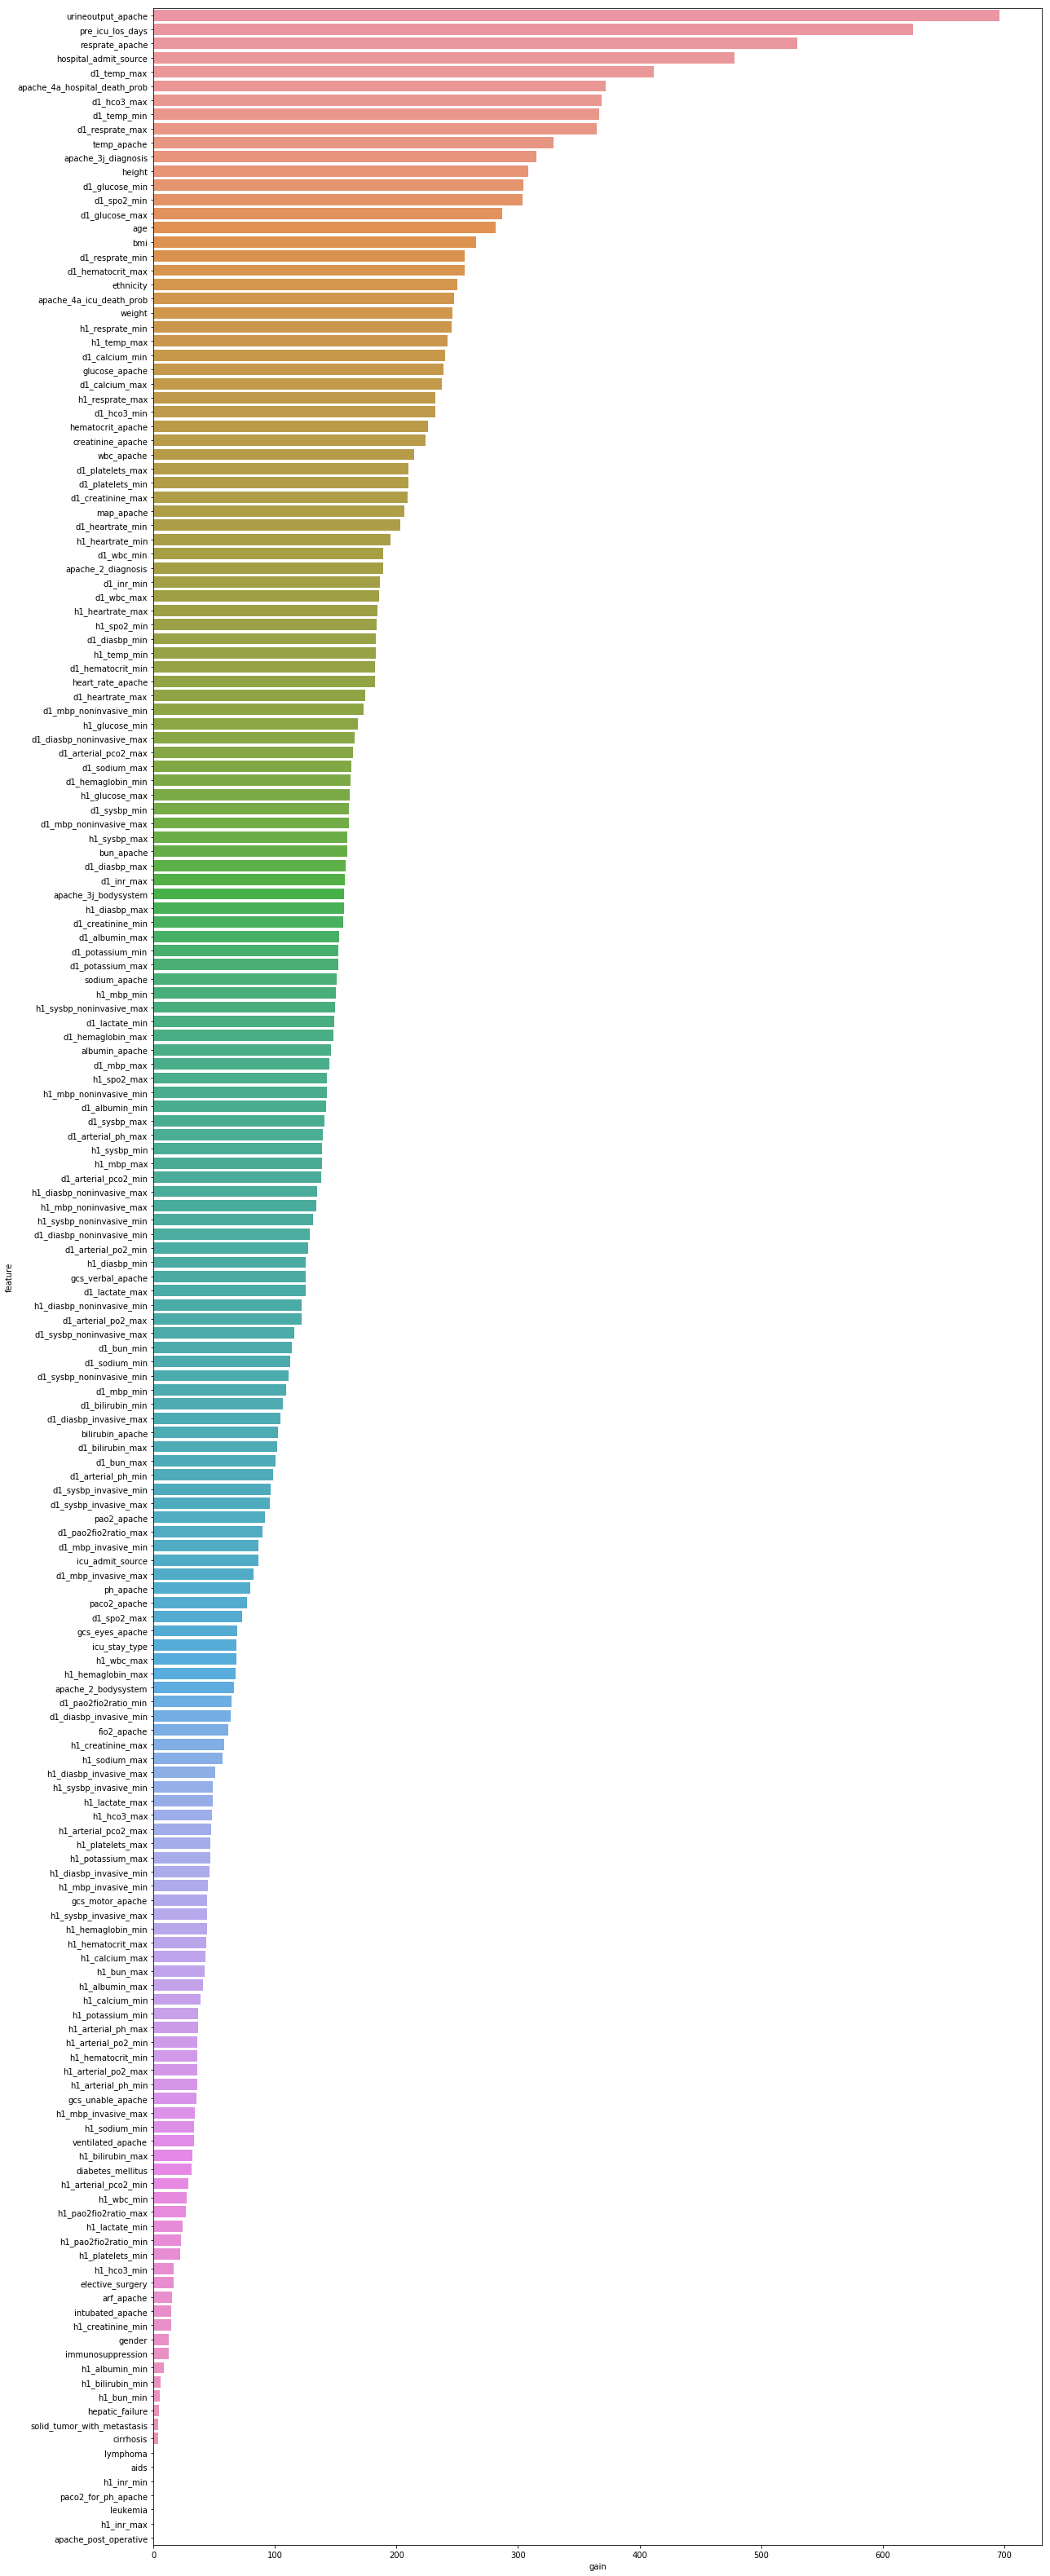

In [76]:
adversarial_features4 = adversarial_features4[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features4= adversarial_features4.sort_values('gain', ascending=False)
plot_importances(adversarial_features4)

urineoutput_apache 0 gain : 696.2


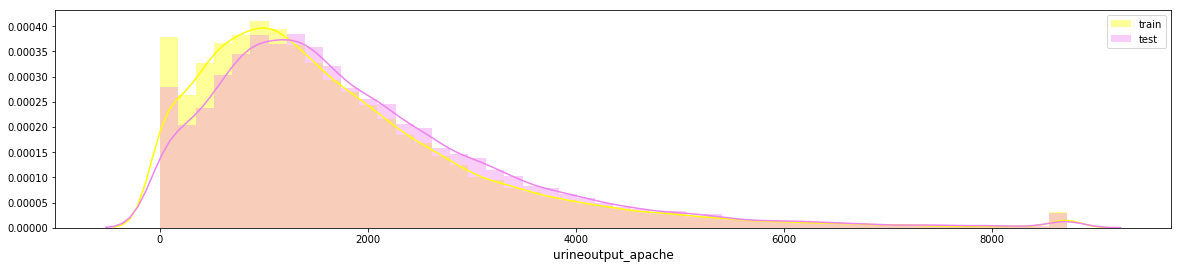

pre_icu_los_days 1 gain : 624.8


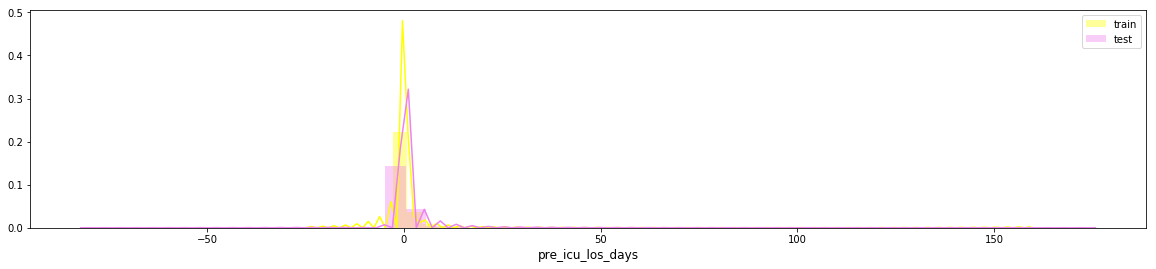

resprate_apache 2 gain : 530.0


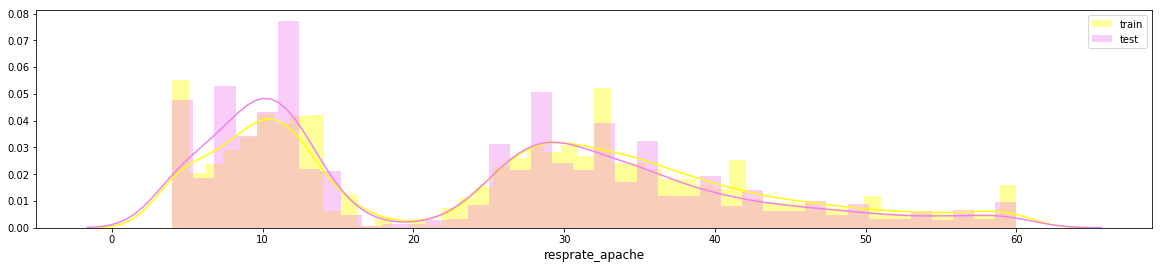

hospital_admit_source 3 gain : 478.4


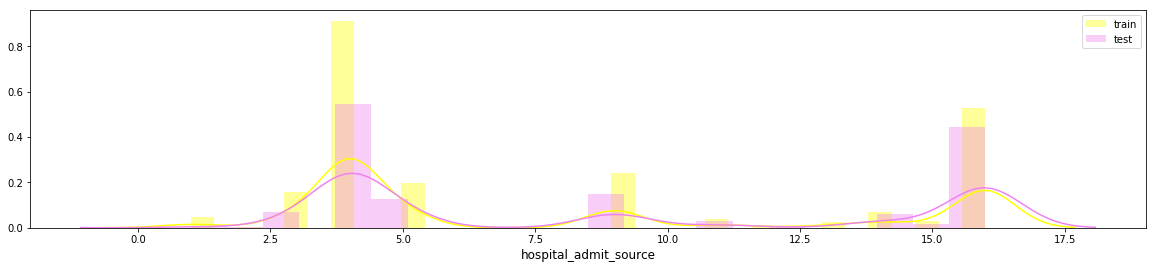

In [77]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features4.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 4:
            print(column,i,"gain :",row['gain'])
            df1      = train.copy()
            df2      = test.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

In [78]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death', 'hospital_id','icu_id','icu_type','urineoutput_apache']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  178


In [79]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950207	valid_1's auc: 0.902297
[200]	training's auc: 0.976014	valid_1's auc: 0.902343
Early stopping, best iteration is:
[115]	training's auc: 0.955232	valid_1's auc: 0.902799
Partial score of fold 0 is: 0.9027990191126783
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949896	valid_1's auc: 0.899286
[200]	training's auc: 0.975667	valid_1's auc: 0.899292
Early stopping, best iteration is:
[126]	training's auc: 0.958059	valid_1's auc: 0.899714
Partial score of fold 1 is: 0.8997144481114224
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.94955	valid_1's auc: 0.903118
[200]	training's auc: 0.97578	valid_1's auc: 0.903458
Early stopping, best iteration is:
[148]	training's auc: 0.964561	valid_1's auc: 0.903875
Partial score of fold 2 is: 0.9038751532165296
Training until validation scores don't improve for 100 rounds.
[100]	tra

In [80]:
## public score is 0.90022 when I remove hospital_id, icu_id, ict type and urineoutput_apache. 
## So it's better to keep urineoutput_apache
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission4.csv",index=False)

After Adversarial Validation, hospital_id, icu_id and icu_type should be removed

In [81]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death', 'hospital_id','icu_id','icu_type']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]


if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.9506	valid_1's auc: 0.902763
[200]	training's auc: 0.976414	valid_1's auc: 0.902853
Early stopping, best iteration is:
[192]	training's auc: 0.974997	valid_1's auc: 0.903183
Partial score of fold 0 is: 0.9031827954233299
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949837	valid_1's auc: 0.898872
[200]	training's auc: 0.975307	valid_1's auc: 0.900456
[300]	training's auc: 0.988544	valid_1's auc: 0.899615
Early stopping, best iteration is:
[214]	training's auc: 0.97795	valid_1's auc: 0.90064
Partial score of fold 1 is: 0.9006401548674233
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949639	valid_1's auc: 0.904122
[200]	training's auc: 0.97525	valid_1's auc: 0.905839
[300]	training's auc: 0.988785	valid_1's auc: 0.90567
[400]	training's auc: 0.995086	valid_1's auc: 0.905052
Early stopping, best iteration is:
[326]	trainin

In [82]:
## Feature Importance from the lightgbm model (gain)
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [83]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

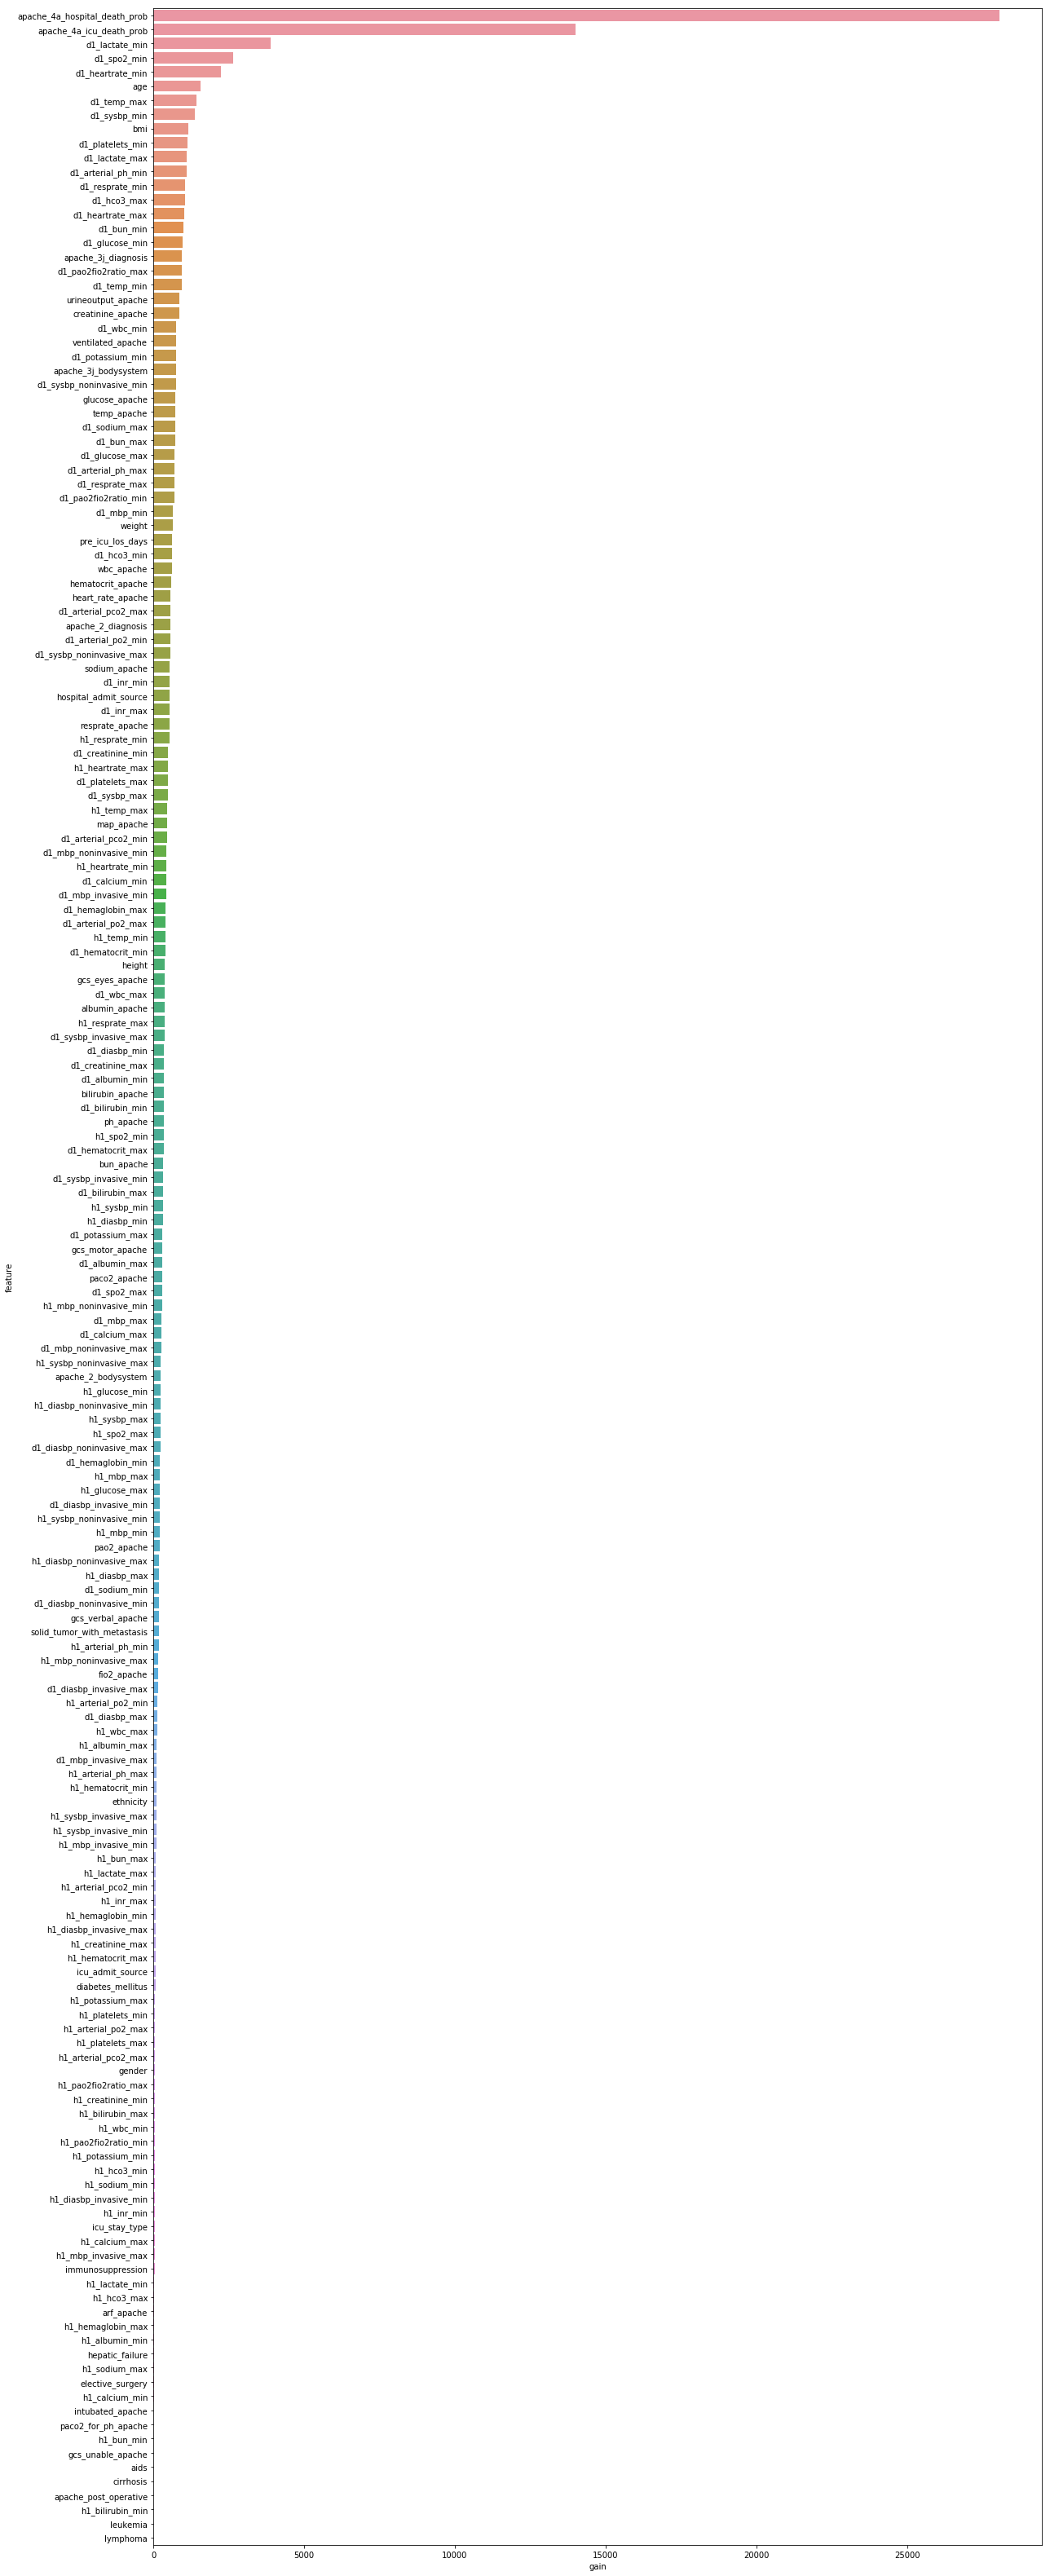

In [84]:
plot_importances(imp_df)

In [89]:
imp_df.sort_values(by='mean_gain', ascending=False)

,feature,gain,split,mean_gain
167,apache_4a_hospital_death_prob,"28,069.67",137,"28,069.67"
168,apache_4a_icu_death_prob,"14,000.89",71,"14,000.89"
112,d1_lactate_min,"3,902.13",68,"3,902.13"
56,d1_spo2_min,"2,637.31",78,"2,637.31"
46,d1_heartrate_min,"2,245.45",99,"2,245.45"
0,age,"1,557.55",99,"1,557.55"
63,d1_temp_max,"1,425.05",98,"1,425.05"
60,d1_sysbp_min,"1,370.86",39,"1,370.86"
1,bmi,"1,160.03",99,"1,160.03"
114,d1_platelets_min,"1,127.16",75,"1,127.16"


In [90]:
imp_df[imp_df.mean_gain==0].feature

14     apache_post_operative
124    h1_bilirubin_min     
169    aids                 
170    cirrhosis            
174    leukemia             
175    lymphoma             
Name: feature, dtype: object

In [94]:
imp_df[imp_df.mean_gain<100].shape

(55, 4)

Remove apache_post_operative, h1_bilirubin_min, aids,cirrhosis, leukemia, and lymphoma 

In [91]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death', 'hospital_id','icu_id','icu_type',
        'apache_post_operative','h1_bilirubin_min','aids','cirrhosis','leukemia','lymphoma']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]


if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949508	valid_1's auc: 0.902836
Early stopping, best iteration is:
[95]	training's auc: 0.947434	valid_1's auc: 0.903095
Partial score of fold 0 is: 0.903095200044627
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949966	valid_1's auc: 0.899449
[200]	training's auc: 0.976092	valid_1's auc: 0.899465
Early stopping, best iteration is:
[168]	training's auc: 0.970093	valid_1's auc: 0.899982
Partial score of fold 1 is: 0.8999822095444286
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950116	valid_1's auc: 0.903152
[200]	training's auc: 0.975921	valid_1's auc: 0.904097
Early stopping, best iteration is:
[191]	training's auc: 0.974109	valid_1's auc: 0.904325
Partial score of fold 2 is: 0.9043247014444944
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950395	valid_1's auc: 0.896971
[200]	tra

In [92]:
## public score is 0.90151 
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission4.csv",index=False)

### Grouping categorical features

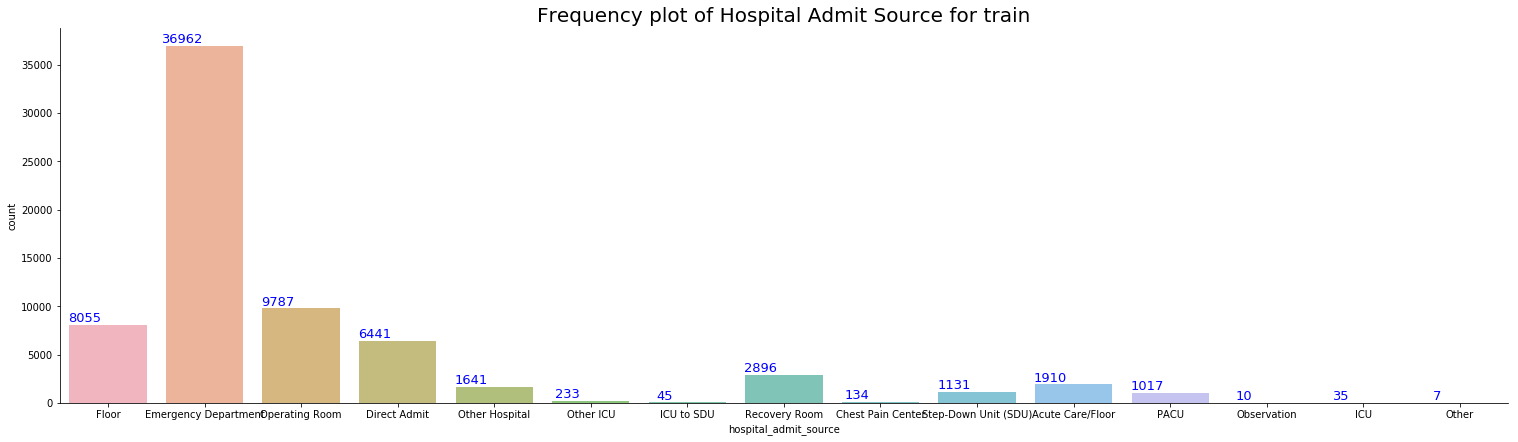

In [5]:
sns.catplot('hospital_admit_source', data= train, kind='count', alpha=0.7, height=6, aspect= 3.5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = train['hospital_admit_source'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of Hospital Admit Source for train', fontsize = 20, color = 'black')
plt.show()

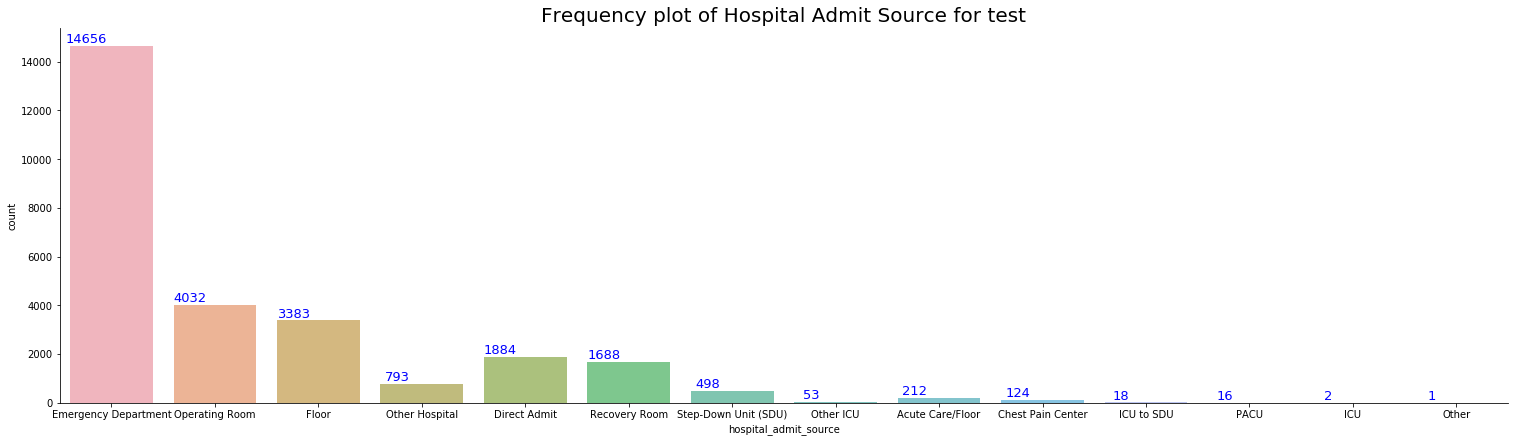

In [6]:
sns.catplot('hospital_admit_source', data= test, kind='count', alpha=0.7, height=6, aspect= 3.5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = test['hospital_admit_source'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of Hospital Admit Source for test', fontsize = 20, color = 'black')
plt.show()

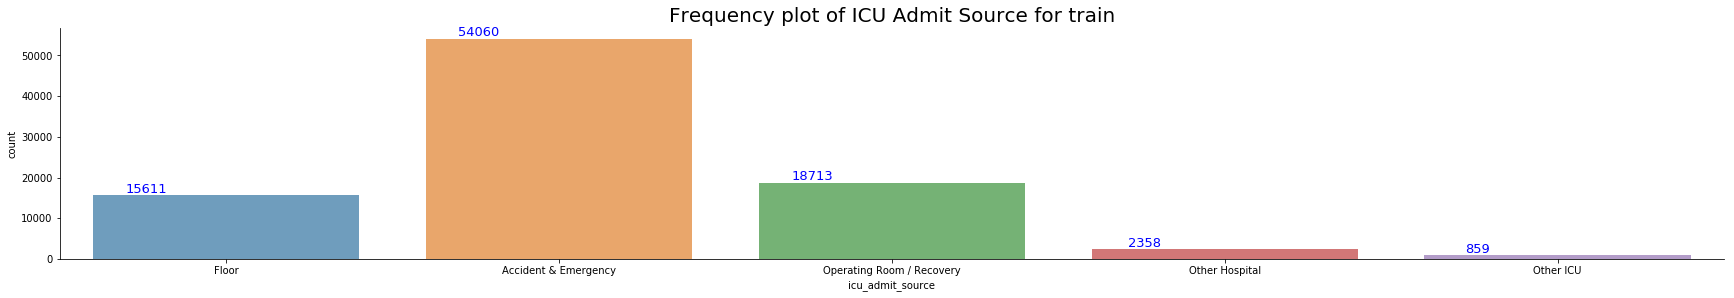

In [7]:
sns.catplot('icu_admit_source', data= train, kind='count', alpha=0.7, height=4, aspect= 6)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = train['icu_admit_source'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of ICU Admit Source for train', fontsize = 20, color = 'black')
plt.show()

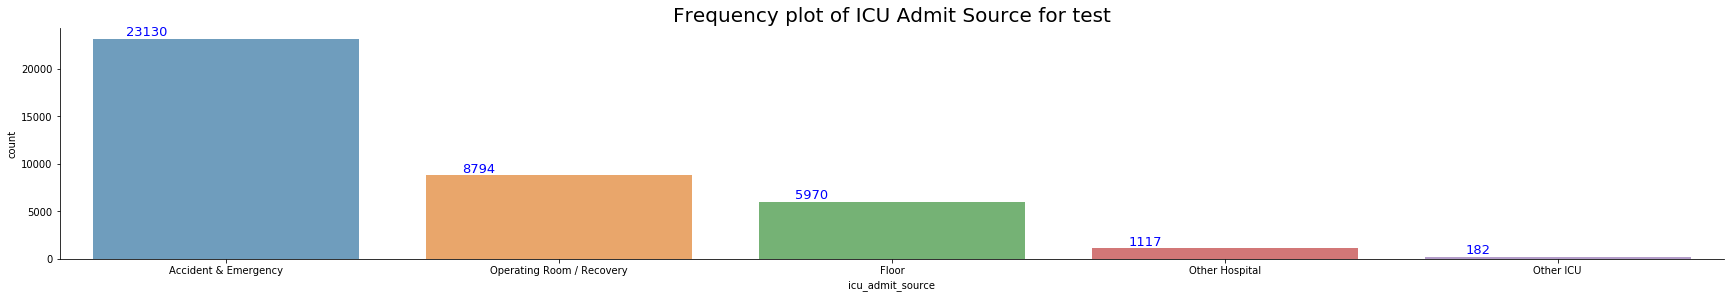

In [8]:
sns.catplot('icu_admit_source', data= test, kind='count', alpha=0.7, height=4, aspect= 6)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = test['icu_admit_source'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of ICU Admit Source for test', fontsize = 20, color = 'black')
plt.show()

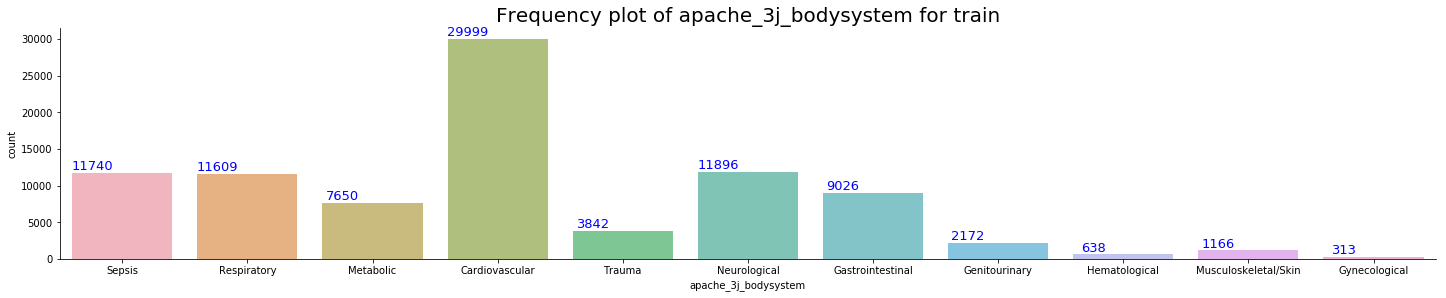

In [9]:
sns.catplot('apache_3j_bodysystem', data= train, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = train['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_3j_bodysystem for train', fontsize = 20, color = 'black')
plt.show()

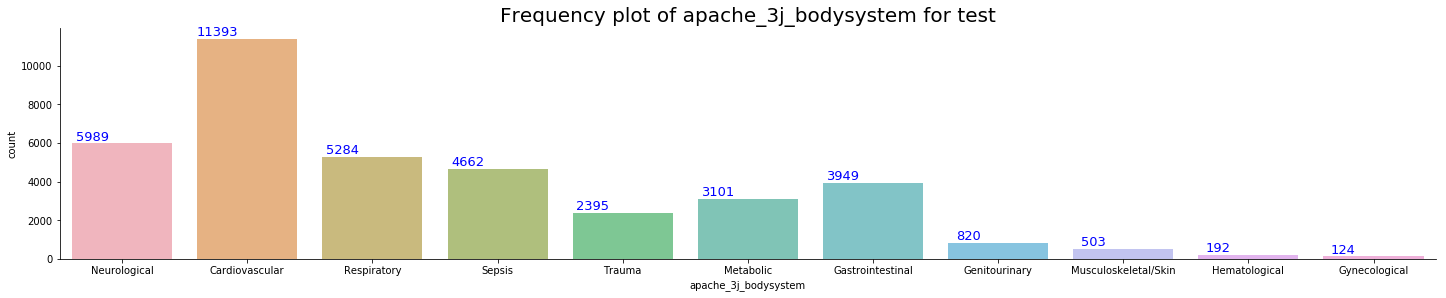

In [10]:
sns.catplot('apache_3j_bodysystem', data= test, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = test['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_3j_bodysystem for test', fontsize = 20, color = 'black')
plt.show()

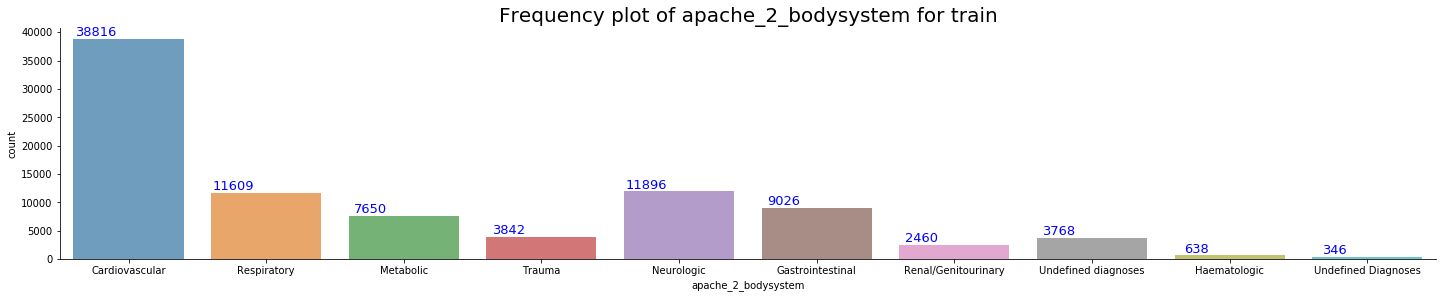

In [11]:
sns.catplot('apache_2_bodysystem', data= train, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
#y_max = train['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_2_bodysystem for train', fontsize = 20, color = 'black')
plt.show()

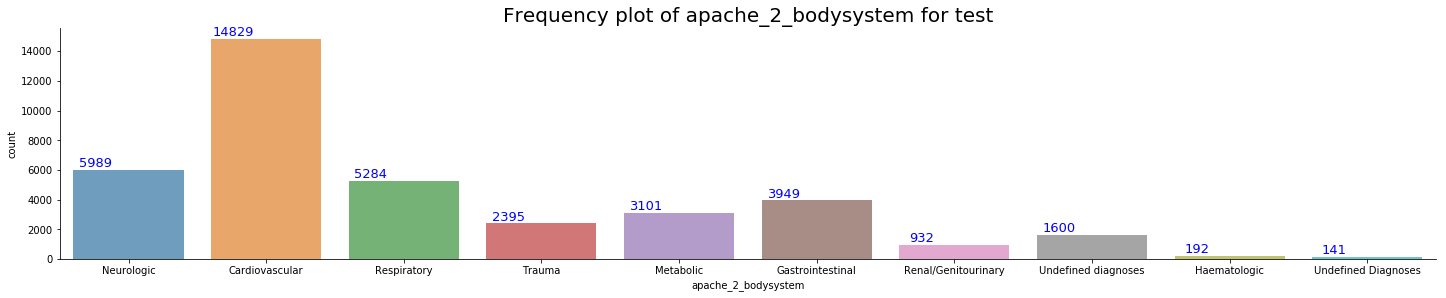

In [12]:
sns.catplot('apache_2_bodysystem', data= test, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
#y_max = test['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_2_bodysystem for test', fontsize = 20, color = 'black')
plt.show()

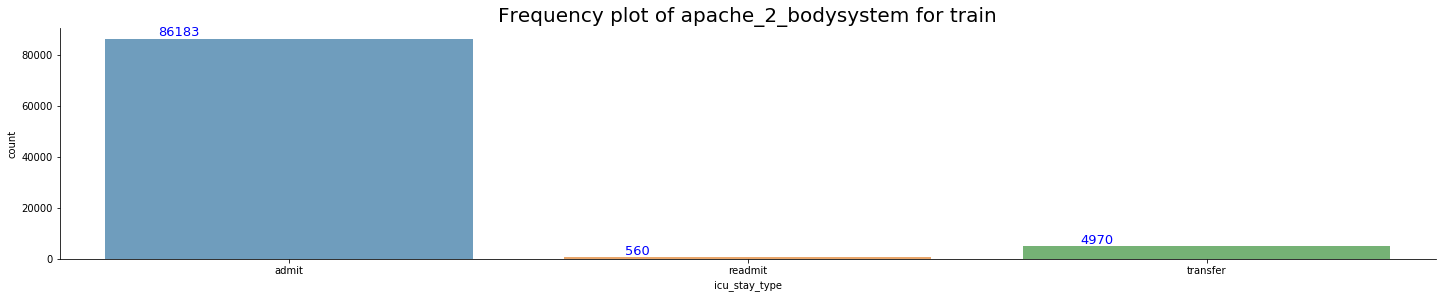

In [16]:
sns.catplot('icu_stay_type', data= train, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
#y_max = train['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_2_bodysystem for train', fontsize = 20, color = 'black')
plt.show()

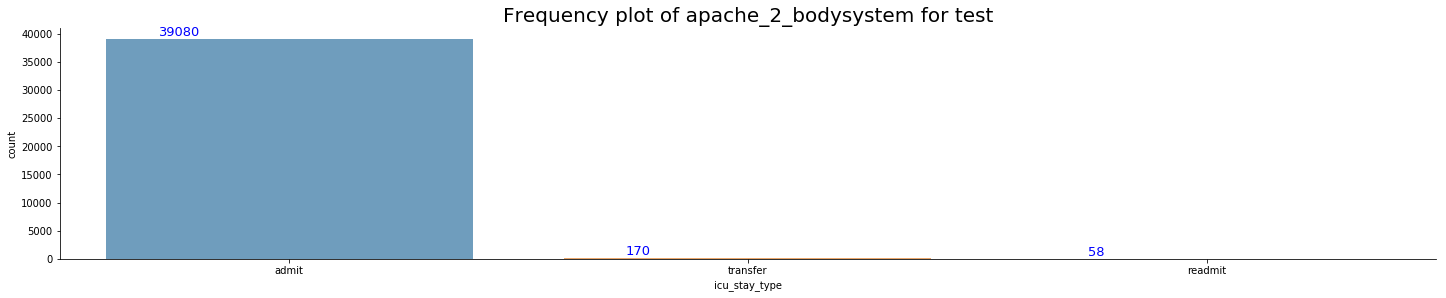

In [15]:
sns.catplot('icu_stay_type', data= test, kind='count', alpha=0.7, height=4, aspect= 5)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
#y_max = test['icu_type'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of apache_2_bodysystem for test', fontsize = 20, color = 'black')
plt.show()

In [4]:
train['hospital_admit_source'] = train['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 
                                                                         'Step-Down Unit (SDU)': 'SDU',
                                                                         'Other Hospital':'Other',
                                                                         'Observation': 'Recovery Room',
                                                                         'Acute Care/Floor': 'Acute Care'})

train['apache_2_bodysystem'] = train['apache_2_bodysystem'].replace({'Undefined diagnoses': 'Undefined Diagnoses'})

# test
test['hospital_admit_source'] = test['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 
                                                                         'Step-Down Unit (SDU)': 'SDU',
                                                                         'Other Hospital':'Other',
                                                                         'Observation': 'Recovery Room',
                                                                         'Acute Care/Floor': 'Acute Care'})

test['apache_2_bodysystem'] = test['apache_2_bodysystem'].replace({'Undefined diagnoses': 'Undefined Diagnoses'})

In [5]:
train_NA=pd.DataFrame(train.isna().sum(), columns=['Count'])
train_NA['% Missing']=100*(train_NA.Count/len(train))
train_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
h1_bilirubin_min,84619,92.27
h1_bilirubin_max,84619,92.27
h1_lactate_max,84369,91.99
h1_lactate_min,84369,91.99
h1_albumin_min,83824,91.40
h1_albumin_max,83824,91.40
h1_pao2fio2ratio_min,80195,87.44
h1_pao2fio2ratio_max,80195,87.44
h1_arterial_ph_max,76424,83.33
h1_arterial_ph_min,76424,83.33


In [6]:
test_NA=pd.DataFrame(test.isna().sum(), columns=['Count'])
test_NA['% Missing']=100*(test_NA.Count/len(test))
test_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
hospital_death,39308,100.00
h1_bilirubin_min,36054,91.72
h1_bilirubin_max,36054,91.72
h1_albumin_min,35984,91.54
h1_albumin_max,35984,91.54
h1_lactate_max,34890,88.76
h1_lactate_min,34890,88.76
h1_pao2fio2ratio_max,33986,86.46
h1_pao2fio2ratio_min,33986,86.46
h1_arterial_pco2_max,32463,82.59
